# Cohort Analysis  ofUK E-Commerce in Python

As e-commerce experiences exponential growth, traditional brick-and-mortar establishments, such as Walmart, are intensifying their online strategies to keep pace with industry giants like Amazon. The recent acquisition of Jet.com by Walmart has significantly contributed to a 40% surge in US e-commerce during the second quarter of 2018. Within the realm of online retail, cohort analysis has emerged as a crucial tool for understanding sales patterns and customer behavior. This analytical approach involves grouping customers into "cohorts" based on acquisition or first purchase dates, enabling businesses to track subsequent activities and delve into essential metrics like customer lifetime value and retention rates. Customer lifetime value reflects the anticipated total profit from a customer across all future interactions, while retention rates measure the percentage of original customers retained over defined time intervals.

This project was sourced from a Github repository to demonstrate the application of Machine Learning in different areas.

In [672]:
import pandas as pd
import seaborn as sb
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from textwrap import wrap

In [628]:
pd.__version__

'0.23.4'

In [629]:
online_data = pd.read_excel('online_retail.xlsx')

A first look at the dataset reveals some interesting variables for each order. As we are looking at the total purchases in particular time periods, it would be useful to create another column for total order amount as well. This is achieved by multiplying unit price with quantity purchased.

In [630]:
online_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [631]:
len(online_data)

541909

In [632]:
main_df = online_data
main_df.columns = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price', 'cust_id','country']
main_df['tot_order'] = main_df['quantity']*main_df['unit_price']
main_df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

         invoice_date  unit_price  cust_id         country  tot_order  
0 2010-12-01 08:26:00        2.55  17850.0  United Kingdom      15.30  
1 2010-12-01 08:26:00        3.39  17850.0  United Kingdom      20.34  
2 2010-12-01 08:26:00        2.75  17850.0  United Kingdom      22.00  
3 2010-12-01 08:26:00        3.39  17850.0  United Kingdom      20.34  
4 2010-12-01 08:26:00        3.39  17850.0  United Kingdom      20.34

In [633]:
main_df.shape

(541909, 9)

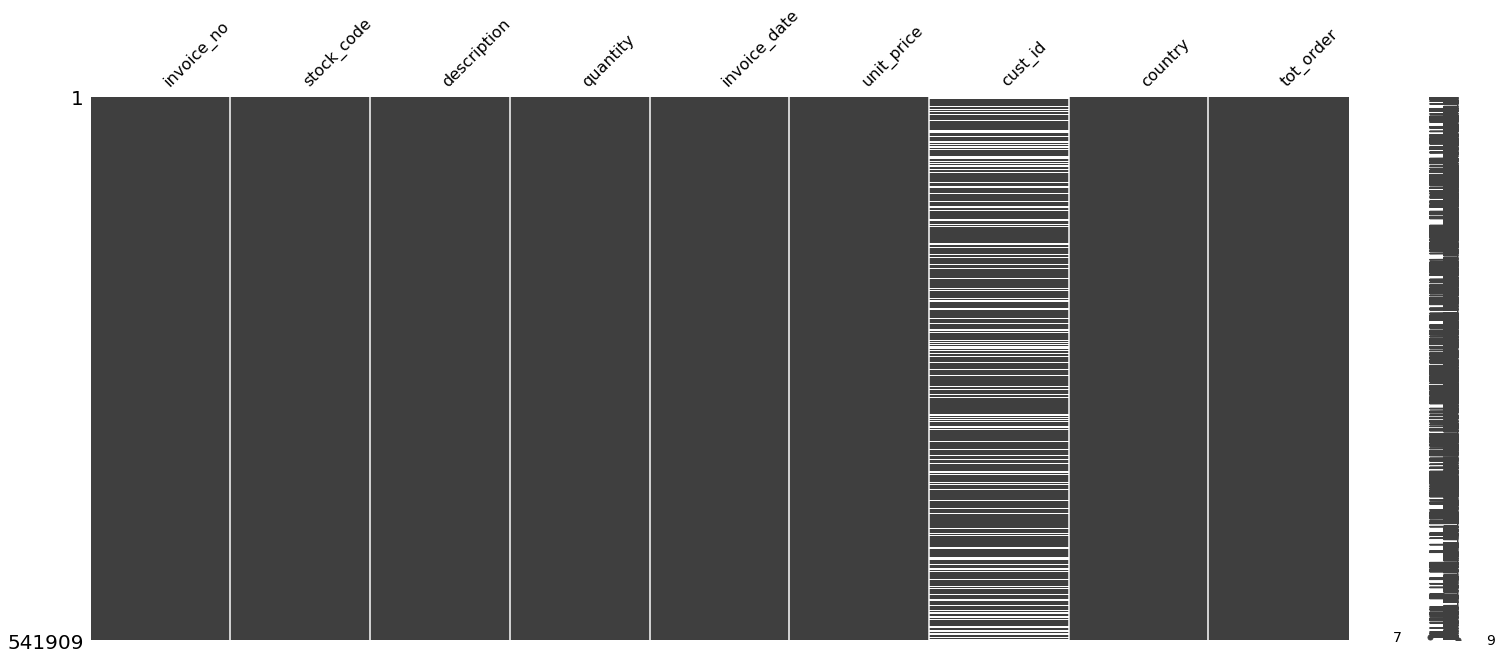

In [634]:
msno.matrix(main_df)

## Missing values

A quick visualization with missingno indicates that there are quite a few missing fields for customer ids. As we need to identify specific customers to place them in cohorts, we will have to drop the orders with missing customer ids. 

In [635]:
main_df = main_df[main_df['cust_id'].isna() == False]
# main_df.reset_index()
# main_df.drop(['index'], axis = 1, inplace=True)
main_df.shape

(406829, 9)

A look at the quantity values also reveal some negative values. These can be intepreted as refunds. As refunds could be interesting for analyses later, we save them in a separate dataframe and remove them from the main dataframe.

As total the quantity and total order values of refunds and the original purchase cancel out when the dataframe is grouped and aggregated later, specific matching orders do not have to be identified

In [636]:
refund_df = main_df[main_df['tot_order'] < 0]
refund_df.head()

invoice_no stock_code                       description  quantity  \
141    C536379          D                          Discount        -1   
154    C536383     35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235    C536391      22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236    C536391      21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237    C536391      21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

           invoice_date  unit_price  cust_id         country  tot_order  
141 2010-12-01 09:41:00       27.50  14527.0  United Kingdom     -27.50  
154 2010-12-01 09:49:00        4.65  15311.0  United Kingdom      -4.65  
235 2010-12-01 10:24:00        1.65  17548.0  United Kingdom     -19.80  
236 2010-12-01 10:24:00        0.29  17548.0  United Kingdom      -6.96  
237 2010-12-01 10:24:00        0.29  17548.0  United Kingdom      -6.96

## Outliers

How about outliers in the data? Are there abnormally large order amounts? 

A look at the distribution for quantity and unit price show that the majority of values are in single digits. There however seems to be outliers of up to 80,995 for order quantity and 38,970 for unit price. 

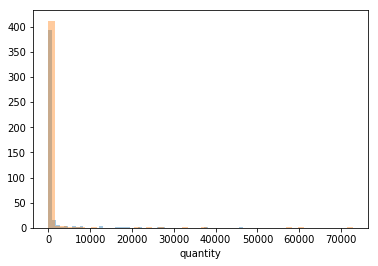

In [654]:
plt = sb.distplot(main_df['unit_price'].value_counts(), kde = False)
plt = sb.distplot(main_df['quantity'].value_counts(), kde = False)

In [655]:
main_df[['quantity', 'unit_price', 'tot_order']].describe()

quantity     unit_price      tot_order
count  405136.000000  405136.000000  405136.000000
mean       12.096437       2.930269      20.456756
std       249.170911       5.507490     422.670565
min    -80995.000000       0.000000 -168469.600000
25%         2.000000       1.250000       4.200000
50%         5.000000       1.950000      10.900000
75%        12.000000       3.750000      19.500000
max     80995.000000    1867.860000  168469.600000

By running a quick filter, we see that the outliers mostly lie in small ticket items  that cost around 1-2 pounds each. The most obvious outlier would be invoice number 581483. It seems that someone really really likes crafted paper birdies. 

In [656]:
main_df[(main_df['quantity'] > 1000) & (main_df['tot_order'] > 5000)]

invoice_no stock_code                          description  quantity  \
52711      540815      21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
61619      541431      23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
160546     550461      21108   FAIRY CAKE FLANNEL ASSORTED COLOUR      3114   
348325     567423      23243  SET OF TEA COFFEE SUGAR TINS PANTRY      1412   
540421     581483      23843          PAPER CRAFT , LITTLE BIRDIE     80995   

              invoice_date  unit_price  cust_id         country  tot_order  
52711  2011-01-11 12:55:00        2.10  15749.0  United Kingdom    6539.40  
61619  2011-01-18 10:01:00        1.04  12346.0  United Kingdom   77183.60  
160546 2011-04-18 13:20:00        2.10  15749.0  United Kingdom    6539.40  
348325 2011-09-20 11:05:00        5.06  17450.0  United Kingdom    7144.72  
540421 2011-12-09 09:15:00        2.08  16446.0  United Kingdom  168469.60

In [657]:
main_df[main_df['tot_order'] == -168469.600000]

invoice_no stock_code                  description  quantity  \
540422    C581484      23843  PAPER CRAFT , LITTLE BIRDIE    -80995   

              invoice_date  unit_price  cust_id         country  tot_order  
540422 2011-12-09 09:27:00        2.08  16446.0  United Kingdom  -168469.6

Judging by this cancellation, maybe not so much ...

There doesn't seem to be any other entries within the outliers to suggest skewing the sales history especially when some of the largest tickets were all cancelled.

What about the unit price outliers? A look at the highest mean values bring up some suspect "products":
1. DOTCOM POSTAGE
2. CRUK Commission
3. Manual
4. Discount

In [658]:
main_df.groupby('description').mean()['unit_price'].nlargest()

description
PICNIC BASKET WICKER 60 PIECES        649.500000
REGENCY MIRROR WITH SHUTTERS          156.428571
RUSTIC  SEVENTEEN DRAWER SIDEBOARD    156.034483
VINTAGE RED KITCHEN CABINET           150.663043
VINTAGE BLUE KITCHEN CABINET          143.653846
Name: unit_price, dtype: float64

'DOTCOM POSTAGE' seems to indicate the amount spent by the customer on postage. With an average of 744, this is over 200 times the average unit price of all products. Furthermore, postage isn't a direct indicator of sales and might skew the amount spent across cohorts. There also seems to be a similar label 'POSTAGE' which we will remove as well.

In [659]:
main_df[main_df['description'] == 'DOTCOM POSTAGE']['unit_price'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: unit_price, dtype: float64

In [660]:
main_df[main_df['description'] == 'DOTCOM POSTAGE'].head()

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, cust_id, country, tot_order]
Index: []

'CRUK Commission' sounded like a fee paid out to an external organization and a quick google search turned up related results at Cancer Research UK. This might be part of an initiative to pay out some proceeds to the cancer research effort. As this isn't directly related to sales, we should drop 'CRUK Commission' rows.

In [661]:
main_df[main_df['description'] == 'CRUK Commission']['unit_price'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: unit_price, dtype: float64

In [662]:
main_df[main_df['description'] == 'CRUK Commission'].head()

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, cust_id, country, tot_order]
Index: []

'Manual' is a product that is rather nebulous. There are 465 records of Manual, with a single record commanding a unit price of 38,970. As we do not have specific information regarding the operations of this online retail company, I am making a guess that 'Manual' refers to manual services rendered with the purchase of other items. This could be the setting up of chandeliers or the shelves in a warehouse. As there are significant outliers for these transactions that do not directly tie to individual product sales, we will drop 'Manual' records too.

In [663]:
main_df[main_df['description'] == 'Manual']['unit_price'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: unit_price, dtype: float64

In [664]:
main_df[(main_df['description'] == 'Manual') & (main_df['unit_price'] > 3000)]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, cust_id, country, tot_order]
Index: []

'Discount' seems to be a rather self explanatory category for discounts offered for products sold. This is further corroborated by the fact that all these transactions have negative sales quantities. As discounts directly tie into the price of products and impact sales directly, we will leave it in the dataframe.

In [665]:
main_df[main_df['description'] == 'Discount']['unit_price'].describe()

count      77.000000
mean       72.484545
std       219.271071
min         0.010000
25%        13.880000
50%        22.970000
75%        57.600000
max      1867.860000
Name: unit_price, dtype: float64

In [666]:
main_df[main_df['description'] == 'Discount'].head()

invoice_no stock_code description  quantity        invoice_date  \
141      C536379          D    Discount        -1 2010-12-01 09:41:00   
9038     C537164          D    Discount        -1 2010-12-05 13:21:00   
14498    C537597          D    Discount        -1 2010-12-07 12:34:00   
19392    C537857          D    Discount        -1 2010-12-08 16:00:00   
31134    C538897          D    Discount        -1 2010-12-15 09:14:00   

       unit_price  cust_id         country  tot_order  
141         27.50  14527.0  United Kingdom     -27.50  
9038        29.29  14527.0  United Kingdom     -29.29  
14498      281.00  15498.0  United Kingdom    -281.00  
19392      267.12  17340.0  United Kingdom    -267.12  
31134        5.76  16422.0  United Kingdom      -5.76

In [667]:
removed_cats = ['DOTCOM POSTAGE', 'CRUK Commission', 'Manual', 'POSTAGE']
main_df = main_df[~main_df['description'].isin(removed_cats)]
main_df.shape

(405136, 9)

In [668]:
main_df.groupby(['country','description']).sum()['tot_order'].nlargest(10)

country         description                       
United Kingdom  REGENCY CAKESTAND 3 TIER              103122.85
                WHITE HANGING HEART T-LIGHT HOLDER     88313.95
                JUMBO BAG RED RETROSPOT                75416.67
                PARTY BUNTING                          61952.58
                ASSORTED COLOUR BIRD ORNAMENT          52314.87
                CHILLI LIGHTS                          45155.61
                PICNIC BASKET WICKER 60 PIECES         39619.50
                PAPER CHAIN KIT 50'S CHRISTMAS         39596.73
                BLACK RECORD COVER FRAME               37799.42
                WOOD BLACK BOARD ANT WHITE FINISH      33408.76
Name: tot_order, dtype: float64

In [669]:
main_df.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
cust_id                float64
country                 object
tot_order              float64
dtype: object

1. DONE cumulative growth
4. DONE top selling items by total sales 
6. average unit price across cohorts
8. DONE average order/total order by country
9. pareto of customers
10. DONE retention cohort
11. DONE look at refunds

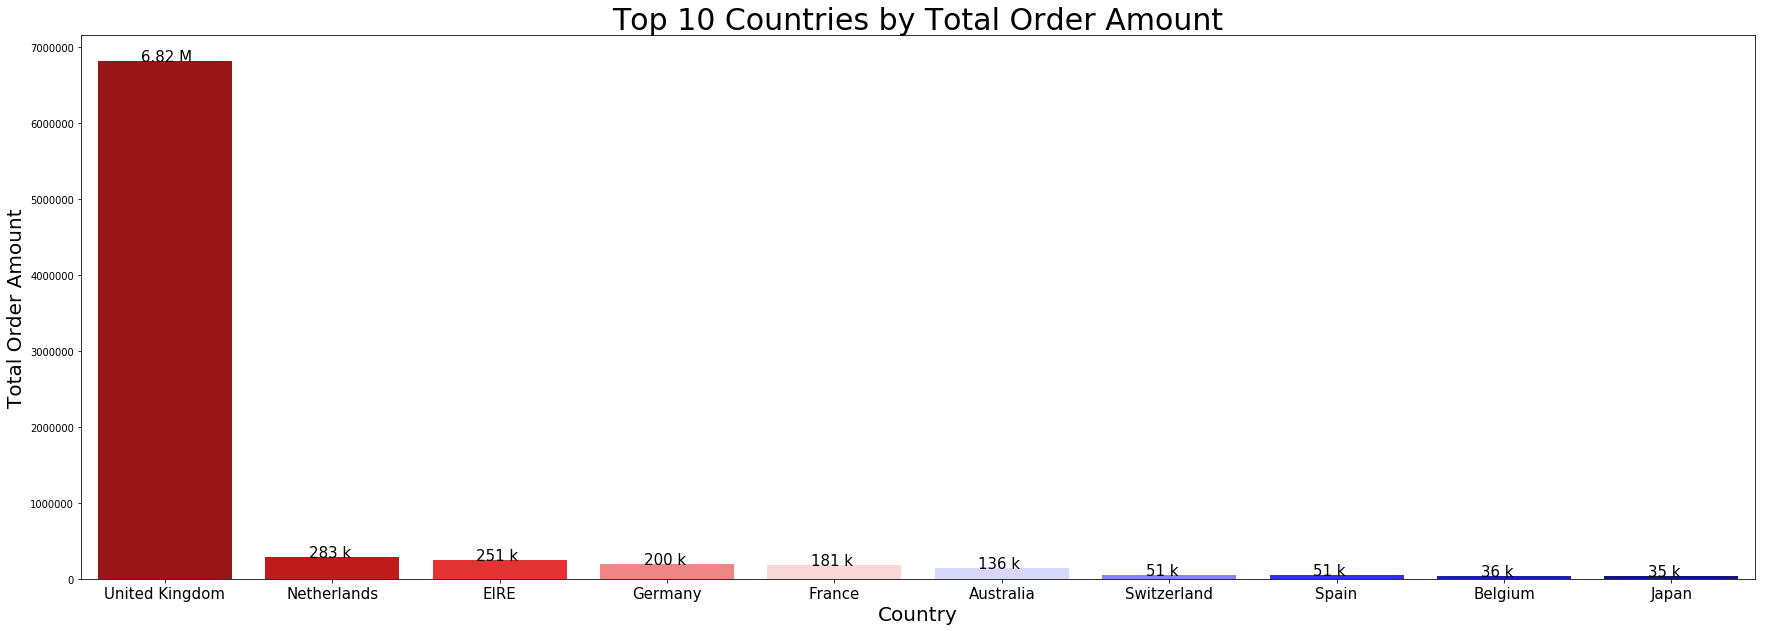

In [673]:
# total order amount by country
country_order = main_df.groupby('country').sum()['tot_order'].nlargest(10)

plt.figure(figsize = (30,10))
ax = sb.barplot(x = country_order.index, y = country_order.values, palette = 'seismic_r')
ax.set_xlabel('Country', fontsize = 20)
ax.set_ylabel('Total Order Amount', fontsize = 20)
ax.set_title('Top 10 Countries by Total Order Amount', fontsize = 30)

labels = [ '\n'.join(wrap(l, 15)) for l in country_order.index ]
ax.set_xticklabels(labels, fontsize = 15)

value_labels = []
for x in country_order.values:
    value_labels.append(str(int(x/1000))+' k')
value_labels[0] = '6.82 M'

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.26, p.get_height() + 2), fontsize = 15)

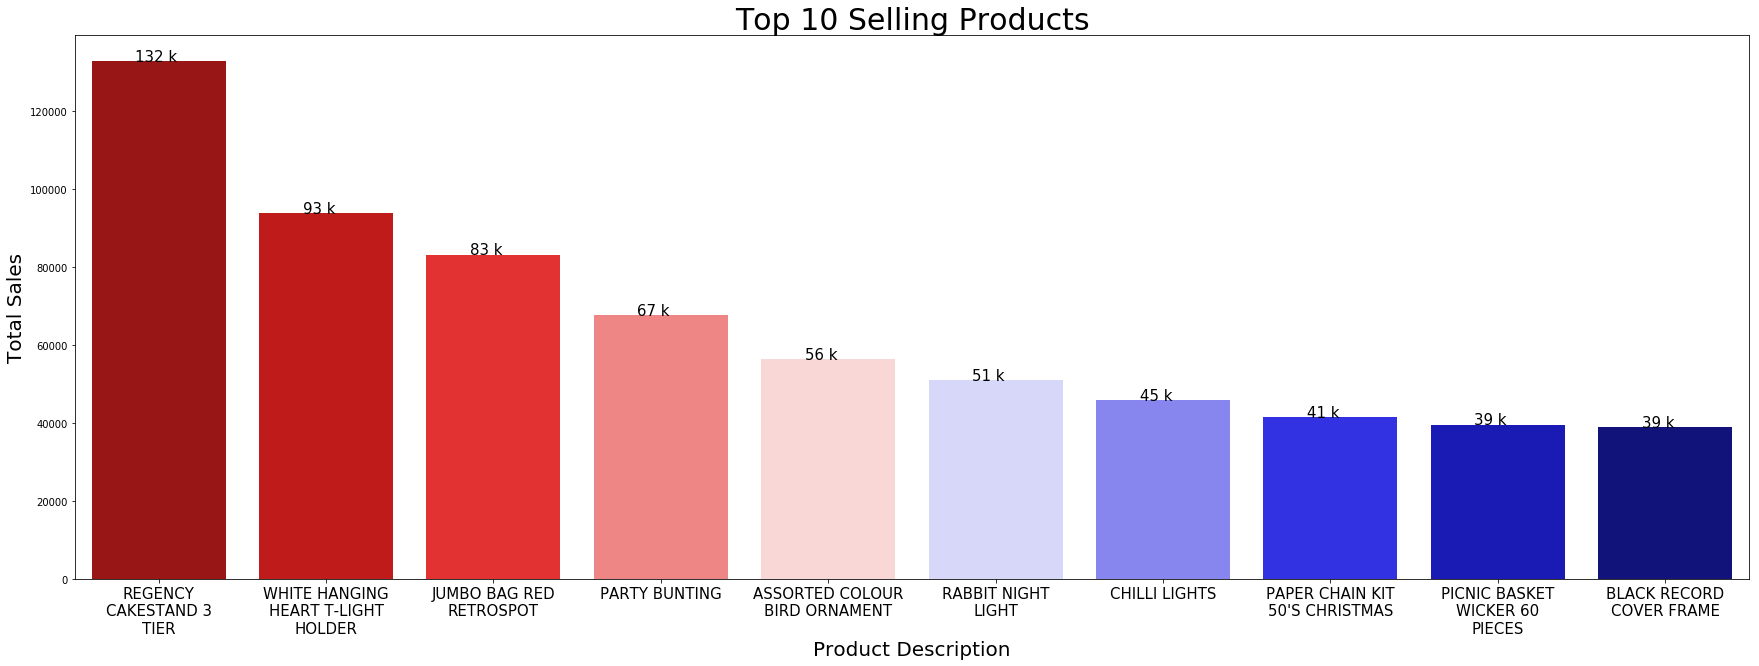

In [674]:
# top selling items by sales
sales_order = main_df.groupby('description').sum()['tot_order'].nlargest(10)

plt.figure(figsize = (30,10))
ax = sb.barplot(x = sales_order.index, y = sales_order.values, palette = 'seismic_r')
ax.set_xlabel('Product Description', fontsize = 20)
ax.set_ylabel('Total Sales', fontsize = 20)
ax.set_title('Top 10 Selling Products', fontsize = 30)

labels = [ '\n'.join(wrap(l, 15)) for l in sales_order.index ]
ax.set_xticklabels(labels, fontsize = 15)

value_labels = []
for x in sales_order.values:
    value_labels.append(str(int(x/1000))+' k')

for p, label in zip(ax.patches, value_labels):
    ax.annotate(label, (p.get_x() + 0.26, p.get_height() + 2), fontsize = 15)

With the top countries and products identified, we can now get into creating cohorts. 

## 1 Creating label for invoice period

We start off with creating a label for invoice date by applying strftime to the datetime object and creating a string representation of the year and month. 

In [675]:
main_df['invoice_period'] = main_df['invoice_date'].apply(lambda x: x.strftime('%Y-%m'))
main_df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

         invoice_date  unit_price  cust_id         country  tot_order  \
0 2010-12-01 08:26:00        2.55  17850.0  United Kingdom      15.30   
1 2010-12-01 08:26:00        3.39  17850.0  United Kingdom      20.34   
2 2010-12-01 08:26:00        2.75  17850.0  United Kingdom      22.00   
3 2010-12-01 08:26:00        3.39  17850.0  United Kingdom      20.34   
4 2010-12-01 08:26:00        3.39  17850.0  United Kingdom      20.34   

  invoice_period  
0        2010-12  
1        2010-12  
2        2010-12  
3        2010-12  
4        2010-12

In [677]:
invoice_period_grouped = main_df.groupby('invoice_period')
invoice_period_agg = invoice_period_grouped.agg({'cust_id': pd.Series.nunique,
                       'description': pd.Series.nunique,
                      'quantity': np.sum,
                      'tot_order': np.sum})
invoice_period_agg.rename(columns ={'cust_id':'total_customers',
                         'description':'total_product_types',
                        'quantity':'total_units'}, inplace = True)
invoice_period_agg

total_customers  total_product_types  total_units    tot_order
invoice_period                                                                
2010-12                   948.0                 2427       295957   549996.100
2011-01                   780.0                 2149       269139   472914.850
2011-02                   794.0                 2140       262820   434945.260
2011-03                  1017.0                 2248       343999   575002.240
2011-04                   896.0                 2234       278383   420368.331
2011-05                  1077.0                 2266       369059   651910.230
2011-06                  1049.0                 2366       356669   641967.370
2011-07                   982.0                 2390       363193   581676.861
2011-08                   977.0                 2395       386998   613232.000
2011-09                  1297.0                 2584       537015   924496.012
2011-10                  1422.0                 2718       568724   962653.620
2011-11                  1707.0                 2724       665825  1119349.940
2011-12                   685.0                 2187       202921   339255.290

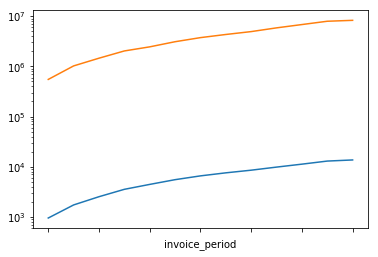

In [678]:
ax = invoice_period_agg['total_customers'].cumsum().plot()
ax2 = invoice_period_agg['tot_order'].cumsum().plot()
ax.set_yscale('log')

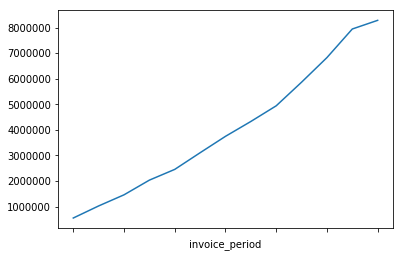

In [679]:
invoice_period_agg['tot_order'].cumsum().plot()

## 2 Creating a label for customer cohort group

As we do not have a sign up date for customers, we give them cohort labels based on their first purchase during this period of time. To do this, we group the transactions by customers and find the minimum of the invoice date. This will be the earliest purchase. The same strftime function is applied to create the new label for cohort group.

In [680]:
main_df.set_index('cust_id', inplace = True)
main_df.head()

invoice_no stock_code                          description  quantity  \
cust_id                                                                        
17850.0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
17850.0     536365      71053                  WHITE METAL LANTERN         6   
17850.0     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
17850.0     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
17850.0     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

               invoice_date  unit_price         country  tot_order  \
cust_id                                                              
17850.0 2010-12-01 08:26:00        2.55  United Kingdom      15.30   
17850.0 2010-12-01 08:26:00        3.39  United Kingdom      20.34   
17850.0 2010-12-01 08:26:00        2.75  United Kingdom      22.00   
17850.0 2010-12-01 08:26:00        3.39  United Kingdom      20.34   
17850.0 2010-12-01 08:26:00        3.39  United Kingdom      20.34   

        invoice_period  
cust_id                 
17850.0        2010-12  
17850.0        2010-12  
17850.0        2010-12  
17850.0        2010-12  
17850.0        2010-12

In [681]:
main_df['cohort_group'] = main_df.groupby(level=0)['invoice_date'].min().apply(lambda x: x.strftime('%Y-%m'))
main_df.head()

invoice_no stock_code                          description  quantity  \
cust_id                                                                        
17850.0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
17850.0     536365      71053                  WHITE METAL LANTERN         6   
17850.0     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
17850.0     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
17850.0     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

               invoice_date  unit_price         country  tot_order  \
cust_id                                                              
17850.0 2010-12-01 08:26:00        2.55  United Kingdom      15.30   
17850.0 2010-12-01 08:26:00        3.39  United Kingdom      20.34   
17850.0 2010-12-01 08:26:00        2.75  United Kingdom      22.00   
17850.0 2010-12-01 08:26:00        3.39  United Kingdom      20.34   
17850.0 2010-12-01 08:26:00        3.39  United Kingdom      20.34   

        invoice_period cohort_group  
cust_id                              
17850.0        2010-12      2010-12  
17850.0        2010-12      2010-12  
17850.0        2010-12      2010-12  
17850.0        2010-12      2010-12  
17850.0        2010-12      2010-12

In [682]:
main_df.reset_index(inplace = True)
main_df.head()

cust_id invoice_no stock_code                          description  \
0  17850.0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1  17850.0     536365      71053                  WHITE METAL LANTERN   
2  17850.0     536365     84406B       CREAM CUPID HEARTS COAT HANGER   
3  17850.0     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4  17850.0     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.   

   quantity        invoice_date  unit_price         country  tot_order  \
0         6 2010-12-01 08:26:00        2.55  United Kingdom      15.30   
1         6 2010-12-01 08:26:00        3.39  United Kingdom      20.34   
2         8 2010-12-01 08:26:00        2.75  United Kingdom      22.00   
3         6 2010-12-01 08:26:00        3.39  United Kingdom      20.34   
4         6 2010-12-01 08:26:00        3.39  United Kingdom      20.34   

  invoice_period cohort_group  
0        2010-12      2010-12  
1        2010-12      2010-12  
2        2010-12      2010-12  
3        2010-12      2010-12  
4        2010-12      2010-12

## 3 Aggregate metrics across cohort groups and invoice periods

Now that we have the labels for when a customer first made a purchase and when individual purchases occured, we can now create some aggregate metrics to represent each time period.

We count the total number of customers and products sold in a period by their unique ids and descriptions. We then sum the quantities sold and total invoice amount to get the aggregate sales figures for the periods.

In [683]:
grouped = main_df.groupby(['cohort_group','invoice_period'])
cohorts = grouped.agg({'cust_id': pd.Series.nunique,
                       'description': pd.Series.nunique,
                      'quantity': np.sum,
                      'tot_order': np.sum})
cohorts.rename(columns ={'cust_id':'total_customers',
                         'description':'total_product_types',
                        'quantity':'total_units'}, inplace = True)
cohorts.head()

total_customers  total_product_types  \
cohort_group invoice_period                                         
2010-12      2010-12                   948.0                 2427   
             2011-01                   361.0                 1833   
             2011-02                   316.0                 1719   
             2011-03                   366.0                 1868   
             2011-04                   340.0                 1792   

                             total_units  tot_order  
cohort_group invoice_period                          
2010-12      2010-12              295957  549996.10  
             2011-01              158817  269782.69  
             2011-02              137715  230727.57  
             2011-03              179302  300720.43  
             2011-04              130568  199453.49

## 4 Creating a label for invoice period within cohort groups

For cohort analysis, it is imperative to identify purchases across the lifetime of this customer. For example, if a customer joined 5 months ago, we would need labels from 1-5 to identify metrics across each month. 

We create this label by first grouping our previous cohorts object by 'cohort_group'. We then find the length of each group and create a list to represent this range with np.arange(). For example, np.arange(5) returns [0, 1, 2, 3, 4].

As we want this list to start with 1, we add 1 to every number in this range.

In [684]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_customers  total_product_types  \
cohort_group invoice_period                                         
2010-12      2010-12                   948.0                 2427   
             2011-01                   361.0                 1833   
             2011-02                   316.0                 1719   
             2011-03                   366.0                 1868   
             2011-04                   340.0                 1792   

                             total_units  tot_order  cohort_period  
cohort_group invoice_period                                         
2010-12      2010-12              295957  549996.10              1  
             2011-01              158817  269782.69              2  
             2011-02              137715  230727.57              3  
             2011-03              179302  300720.43              4  
             2011-04              130568  199453.49              5

## User Retention

Text(0.5,1,'Retention Rates Across Cohorts')

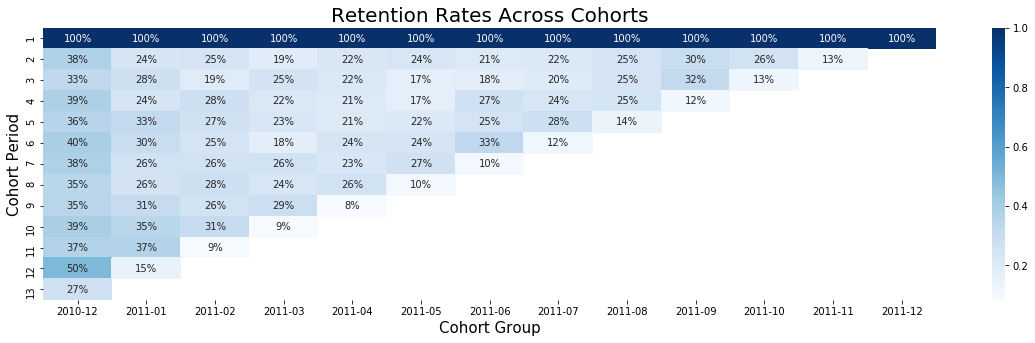

In [700]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

cohort_sizes = cohorts.groupby(level=0)['total_customers'].first()
user_retention = cohorts['total_customers'].unstack(0).divide(cohort_sizes, axis = 1)
plt.figure(figsize=(20,5))
ax = sb.heatmap(user_retention, annot=True,cmap='Blues', fmt='.0%')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Retention Rates Across Cohorts', fontsize = 20)

## Sales across cohorts

Text(0.5,1,'Monthly Total Sales Across Cohorts')

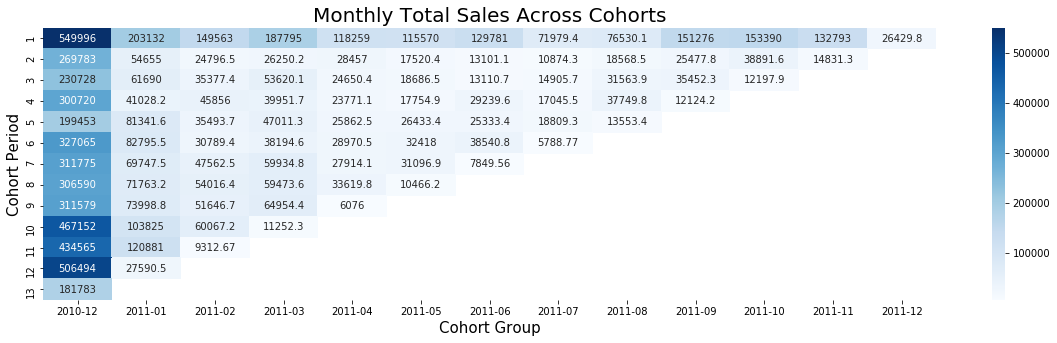

In [698]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

unstacked_order = cohorts['tot_order'].unstack(0)
plt.figure(figsize=(20,5))
ax = sb.heatmap(unstacked_order, annot=True,cmap='Blues', fmt='g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Total Sales Across Cohorts', fontsize = 20)

Text(0.5,1,'Monthly Active Customers Across Cohorts')

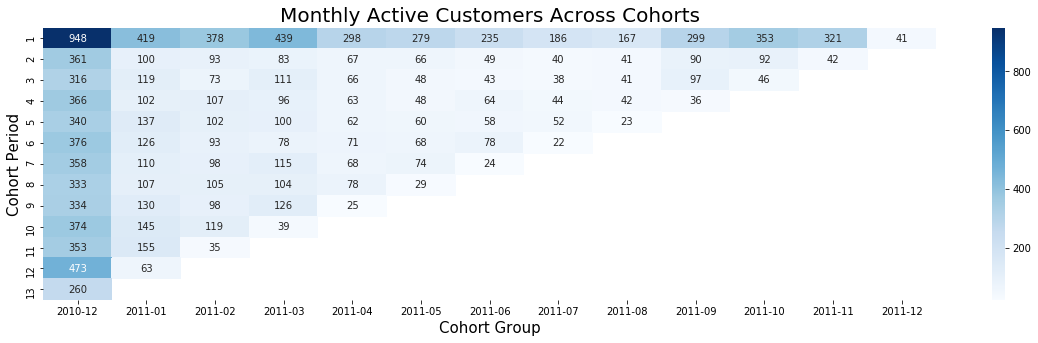

In [697]:
unstacked_cust = cohorts['total_customers'].unstack(0)
plt.figure(figsize=(20,5))
ax = sb.heatmap(unstacked_cust, annot = True, cmap='Blues', fmt = 'g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Active Customers Across Cohorts', fontsize = 20)

In [688]:
# # time series

# time_df = main_df.set_index('invoice_date')

# %matplotlib inline
# agg_df = pd.concat([time_df['unit_price'],time_df['tot_order'].rolling(30).mean()], axis = 1)
# agg_df.plot(figsize=(20,10), linewidth=5, fontsize=20)

## Refunds/Cancellations

Lets take a look at refunds and what the most frequent and largest refunds are.

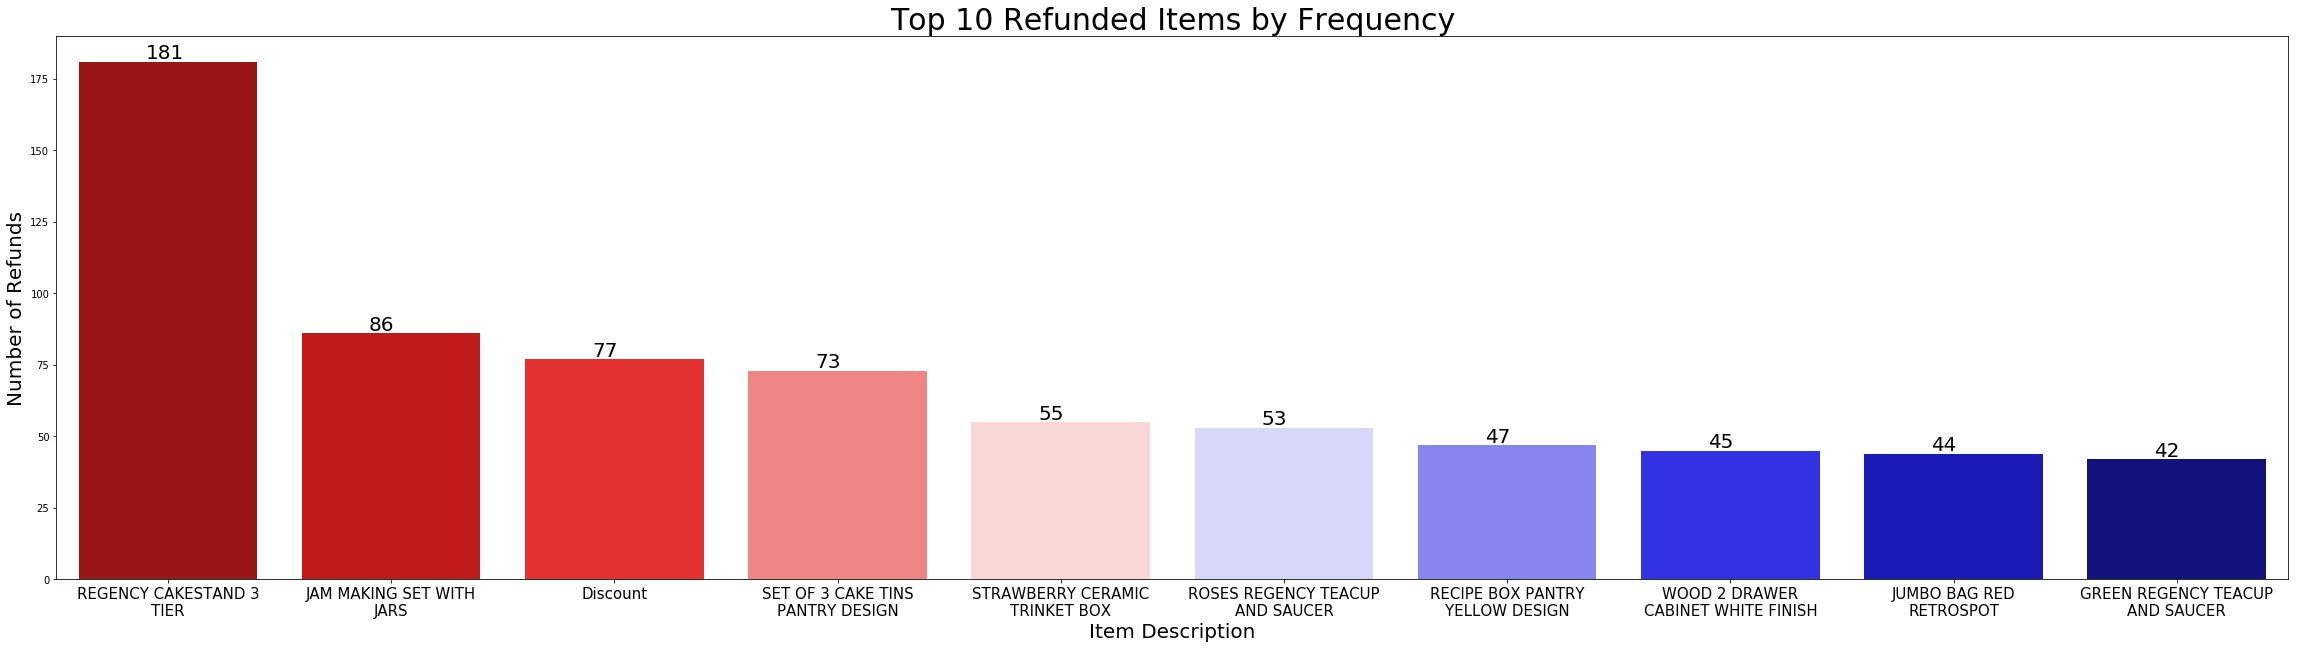

In [689]:
refund_df = refund_df[~refund_df['description'].isin(removed_cats)]

plt.figure(figsize = (40,10))
ax = sb.barplot(x = refund_df['description'].value_counts().nlargest(10).index, y = refund_df['description'].value_counts().nlargest(10).values, palette = 'seismic_r')
ax.set_xlabel('Item Description', fontsize = 20)
ax.set_ylabel('Number of Refunds', fontsize = 20)
ax.set_title('Top 10 Refunded Items by Frequency', fontsize = 30)

labels = [ '\n'.join(wrap(l, 20)) for l in refund_df['description'].value_counts().nlargest(10).index ]
ax.set_xticklabels(labels, fontsize = 15)

for p, label in zip(ax.patches, refund_df['description'].value_counts().nlargest(10).values):
    ax.annotate(label, (p.get_x() + 0.3, p.get_height() + 1), fontsize = 20)


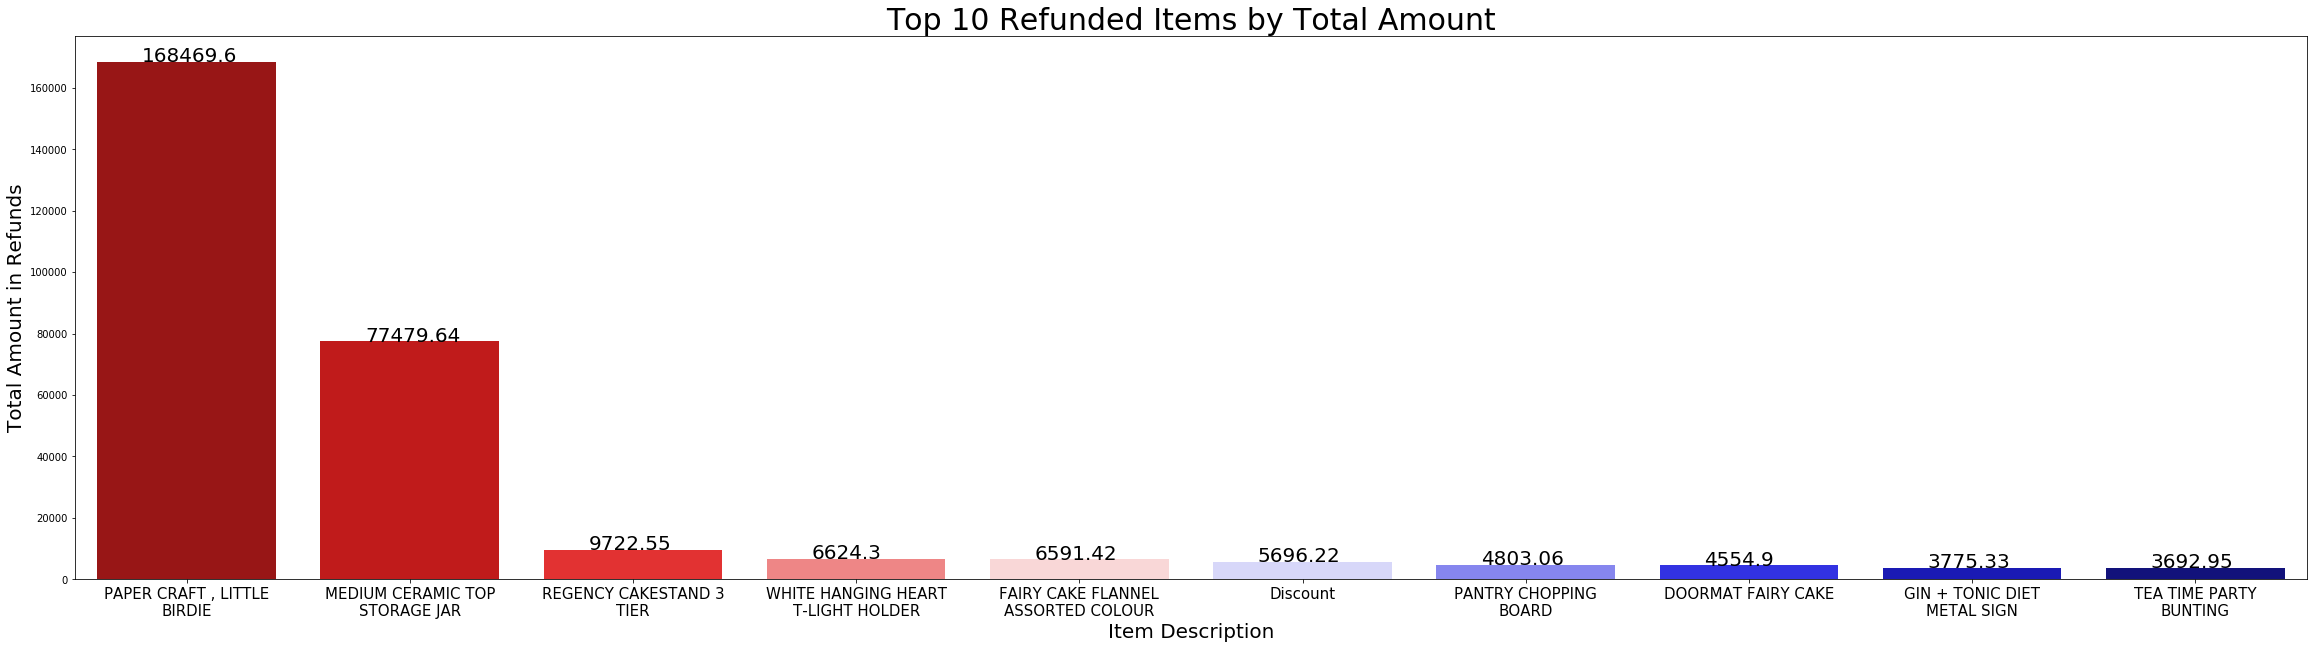

In [690]:
top_refund_amt = -refund_df.groupby('description').sum()['tot_order'].nsmallest(10)

plt.figure(figsize = (40,10))
ax = sb.barplot(x = top_refund_amt.index, y = top_refund_amt.values, palette = 'seismic_r')
ax.set_xlabel('Item Description', fontsize = 20)
ax.set_ylabel('Total Amount in Refunds', fontsize = 20)
ax.set_title('Top 10 Refunded Items by Total Amount', fontsize = 30)

labels = [ '\n'.join(wrap(l, 20)) for l in top_refund_amt.index ]
ax.set_xticklabels(labels, fontsize = 15)

for p, label in zip(ax.patches, top_refund_amt.values):
    ax.annotate(label, (p.get_x() + 0.2, p.get_height() + 10), fontsize = 20)

In [691]:
large_refunds = refund_df['tot_order'].nsmallest(10).index
for refund in large_refunds:
    print(-refund_df.loc[refund]['quantity'], ' units of ', refund_df.loc[refund]['description'], ' refunded at ', -refund_df.loc[refund]['tot_order'])

80995  units of  PAPER CRAFT , LITTLE BIRDIE  refunded at  168469.6
74215  units of  MEDIUM CERAMIC TOP STORAGE JAR  refunded at  77183.6
3114  units of  FAIRY CAKE FLANNEL ASSORTED COLOUR  refunded at  6539.4
1930  units of  WHITE HANGING HEART T-LIGHT HOLDER  refunded at  4921.5
670  units of  DOORMAT FAIRY CAKE  refunded at  4522.5
756  units of  PANTRY CHOPPING BOARD  refunded at  3825.36
2000  units of  GIN + TONIC DIET METAL SIGN  refunded at  3700.0
1300  units of  TEA TIME PARTY BUNTING  refunded at  3315.0
318  units of  IVORY DINER WALL CLOCK  refunded at  2432.7
1  units of  Discount  refunded at  1867.86
